# Shifting Mean Anomaly

In [1]:
import matplotlib.pyplot as plt
plt.style.use('rcparams.mplstyle')
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import numpy as np
from calcwf import gen_wf, chirp2total, shifted_f, shifted_e

The plot in this notebook demonstrates a waveform starting $2\pi$ earlier in mean anomaly by calculating the change in frequency and eccentricity to recover the original waveform after exactly one amplitude modulation.

In [2]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

In [3]:
# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f = shifted_f(f_low, e, chirp2total(chirp, q), q)
s_e = shifted_e(s_f, f_low, e)

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

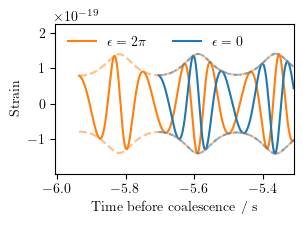

In [14]:
# Make plot
plt.figure(figsize=(0.49*6.4,0.49*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label='$\epsilon=2\pi$')
plt.plot(h.sample_times, h.real(), c='C0', label='$\epsilon=0$')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
len_2pi = h.sample_times[0]-s.sample_times[0]
plt.xlim(s.sample_times[0]-0.3*len_2pi, h.sample_times[0]+1.7*len_2pi)
max_h = max(np.abs(h[:int(1.7*len_2pi*sample_rate)]))
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()
plt.savefig('Figures/2piTA.pgf')